# **Klasifikasi Gambar Cancer Melanomena**

Sumber Dataset: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

# Import Libraries

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mfakhrizalna","key":"1be53a3acbd588b191f871415367893b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
!unzip melanoma-skin-cancer-dataset-of-10000-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_643.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_644.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_645.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_646.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_647.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_648.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_649.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_65.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_650.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_651.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_652.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_653.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_654.jpg  
  inflating: melanoma_cancer_dataset/train/benign/mel

# Membagi dataset menjadi test, train, val

In [6]:
# Path awal
base_dir = 'melanoma_cancer_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Buat folder val dan subfoldernya
os.makedirs(val_dir, exist_ok=True)
for cls in ['benign', 'malignant']:
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    src_folder = os.path.join(train_dir, cls)
    dst_folder = os.path.join(val_dir, cls)

    images = os.listdir(src_folder)
    random.shuffle(images)

    val_count = int(0.2 * len(images))  # 20% untuk val

    for img in images[:val_count]:
        src = os.path.join(src_folder, img)
        dst = os.path.join(dst_folder, img)
        shutil.move(src, dst)

print("Dataset telah dibagi menjadi train, test, dan val.")

Dataset telah dibagi menjadi train, test, dan val.


**Plot semua sampel kelas**

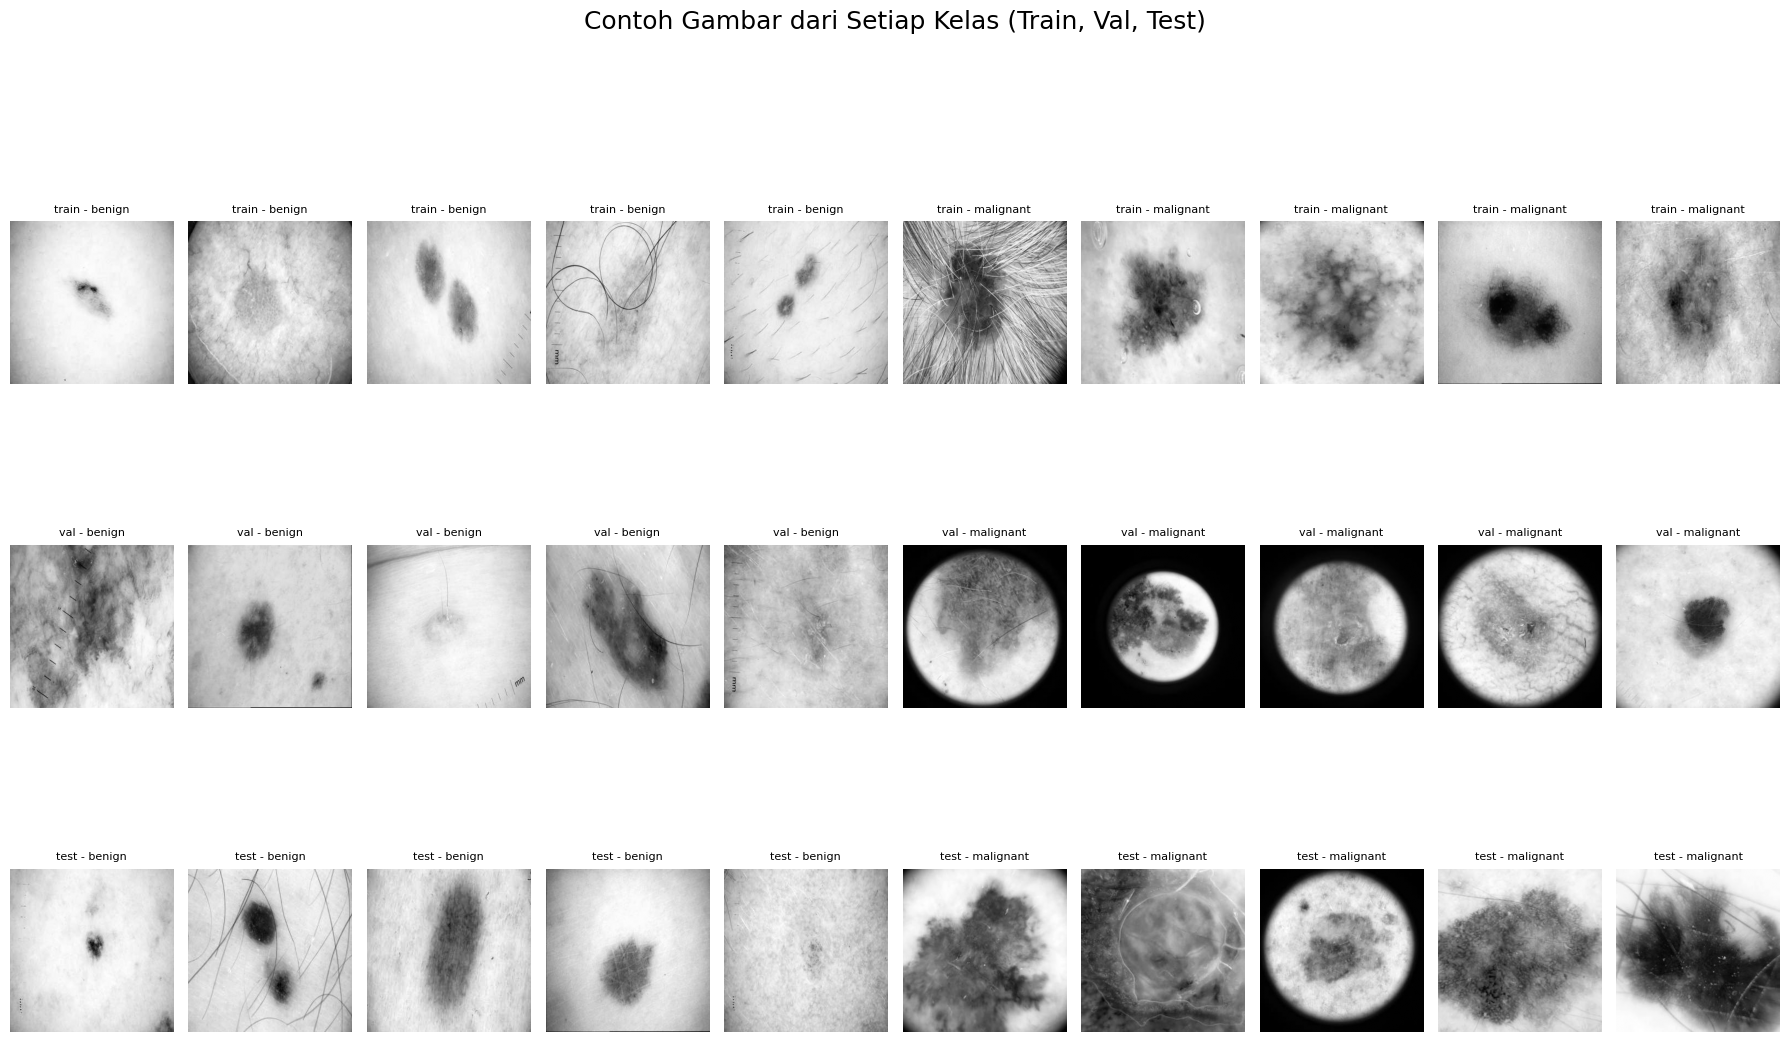

In [8]:
# Path dasar dataset
base_path = "melanoma_cancer_dataset"

# Subset yang ingin ditampilkan
subsets = ["train", "val", "test"]

# Ukuran subplot
fig, axs = plt.subplots(
    len(subsets), 5 * len(os.listdir(os.path.join(base_path, subsets[0]))),
    figsize=(18, 4 * len(subsets))
)

if len(subsets) == 1:
    axs = [axs]  # Kalau hanya 1 subset, bungkus ke list

# Loop tiap subset
for row_idx, subset in enumerate(subsets):
    subset_path = os.path.join(base_path, subset)

    # Loop tiap kelas
    class_names = sorted(os.listdir(subset_path))
    for col_idx, class_name in enumerate(class_names):
        class_path = os.path.join(subset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        if len(images) < 5:
            continue  # Lewati jika gambar tidak cukup

        sampled_images = np.random.choice(images, 5, replace=False)

        for i, image_name in enumerate(sampled_images):
            ax = axs[row_idx][col_idx * 5 + i] if len(subsets) > 1 else axs[col_idx * 5 + i]
            img_path = os.path.join(class_path, image_name)
            img = Image.open(img_path).convert("L")
            ax.imshow(img, cmap='gray')
            ax.set_title(f"{subset} - {class_name}", fontsize=8)
            ax.axis('off')

fig.suptitle("Contoh Gambar dari Setiap Kelas (Train, Val, Test)", fontsize=18)
fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

**Plot distribusi gambar semua kelas**

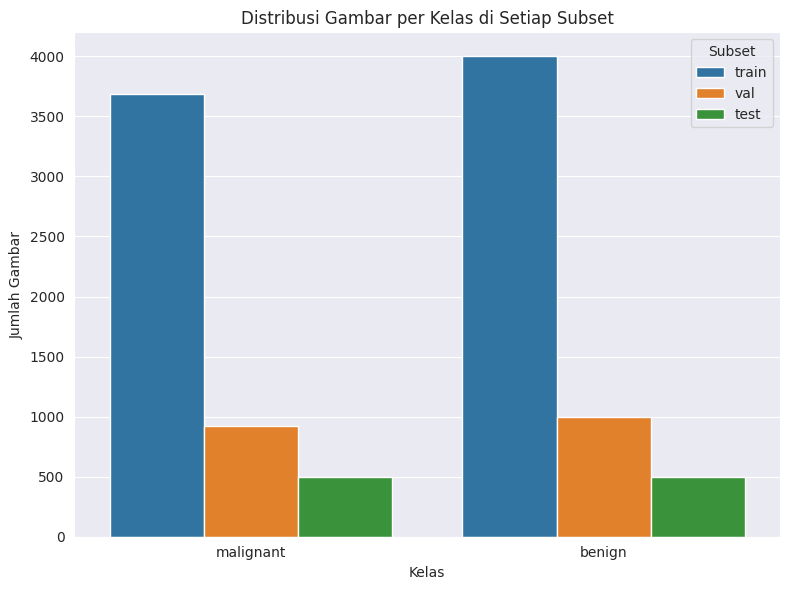

In [9]:
# Path dasar dataset
base_path = "melanoma_cancer_dataset"

# Subset yang tersedia
subsets = ["train", "val", "test"]

# Inisialisasi list
file_name = []
labels = []
full_path = []
split_type = []

# Looping semua subset
for subset in subsets:
    subset_path = os.path.join(base_path, subset)

    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)

        if not os.path.isdir(class_path):
            continue

        for name in os.listdir(class_path):
            file_name.append(name)
            labels.append(class_name)
            full_path.append(os.path.join(class_path, name))
            split_type.append(subset)

# Buat DataFrame
distribution_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels,
    "split": split_type
})

# Plot distribusi kelas di seluruh dataset
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="labels", hue="split")
plt.title("Distribusi Gambar per Kelas di Setiap Subset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.legend(title="Subset")
plt.tight_layout()
plt.show()

# Data Augmentasi

In [10]:
# Path ke dataset
base_dir = 'melanoma_cancer_dataset'

# Ukuran gambar
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [11]:
# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Data validation & test tidak perlu augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    directory=base_dir + '/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    directory=base_dir + '/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    directory=base_dir + '/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # penting agar hasil prediksi dan ground truth bisa cocok
)

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Modelling dengan CNN

In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Karena hanya 2 kelas (binary)
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Penerapan callback dan Prosess Training Data**

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step - accuracy: 0.6816 - loss: 0.6489 - val_accuracy: 0.8662 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1012s 4s/step - accuracy: 0.8537 - loss: 0.3583 - val_accuracy: 0.8917 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 985s 4s/step - accuracy: 0.8669 - loss: 0.3185 - val_accuracy: 0.8943 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.8636 - loss: 0.3235 - val_accuracy: 0.8943 - val_loss: 0.2700 - learning_rate: 0.0010
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1008s 4s/step - accuracy: 0.8766 - loss: 0.2961 - val_accuracy: 0.8553 - val_loss: 0.3565 - learning_rate: 0.0010
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1019s 4s/step - accuracy: 0.8644 - loss: 0.3195 - val_accuracy: 0.8886 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 1008s 4s/step - accuracy: 0.8886 - loss

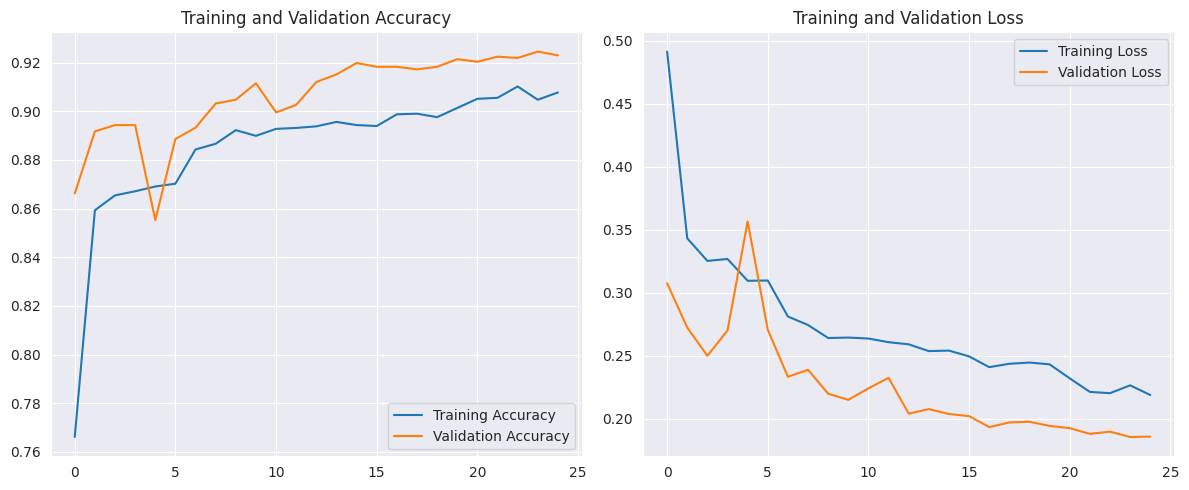

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Evaluasi Model

In [15]:
# Evaluasi
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Accuracy dan Loss Train
train_loss = history.history['loss'][-1]
print(f'Train Loss: {train_loss:.4f}')
train_accuracy = history.history['accuracy'][-1]
print(f'Train Accuracy: {train_accuracy:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9111 - loss: 0.2132
Test Loss: 0.2196
Test Accuracy: 0.9060
Train Loss: 0.2187
Train Accuracy: 0.9077




              precision    recall  f1-score   support

      benign     0.8874    0.9300    0.9082       500
   malignant     0.9265    0.8820    0.9037       500

    accuracy                         0.9060      1000
   macro avg     0.9069    0.9060    0.9059      1000
weighted avg     0.9069    0.9060    0.9059      1000



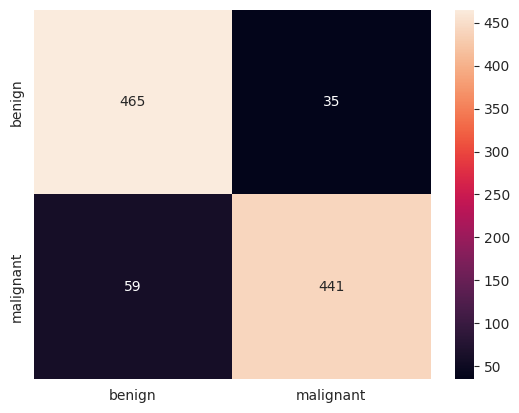

In [19]:
test_generator.reset()

# Ganti model_1 dengan model
preds_1 = model.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["benign", "malignant"],
columns=["benign", "malignant"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['benign','malignant'], digits=4))

# Menyimpan model dengan format (SavedModel, TF-Lite, TFJS)

**Format SavedModel**

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!mkdir -p /content/drive/MyDrive/Submission_proyek_klasifikasi_gambar
!cp -r saved_model /content/drive/MyDrive/Submission_proyek_klasifikasi_gambar/

**Format TFLite**

In [42]:
# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Path tujuan di Google Drive
drive_path = '/content/drive/MyDrive/Submission_proyek_klasifikasi_gambar/tflite'
os.makedirs(drive_path, exist_ok=True)

# Simpan model .tflite
with open(os.path.join(drive_path, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)

# Ambil label dari train_generator
class_indices = train_generator.class_indices
labels = list(class_indices.keys())

# Simpan label ke label.txt
with open(os.path.join(drive_path, 'label.txt'), 'w') as f:
    for label in labels:
        f.write(label + '\n')

print('Model dan label.txt berhasil disimpan di Google Drive 🎉')

Saved artifact at '/tmp/tmpv0nnz917'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140049112640848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049112641616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049112644496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049112642768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049112643920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049112645264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049112641040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049112643344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049074127312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140049074128848: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model dan label.

**Format TFJS**

In [22]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [32]:
from google.colab import drive
drive.mount('/content/drive')

# Import the tensorflowjs library
import tensorflowjs as tfjs

# Define the output directory on your Google Drive
output_dir = '/content/drive/MyDrive/Submission_proyek_klasifikasi_gambar/tfjs_model'

import os
os.makedirs(output_dir, exist_ok=True)

# Use the imported tfjs module
tfjs.converters.save_keras_model(model, output_dir)

print(f"Model berhasil dikonversi ke TFJS dan disimpan di: {output_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke TFJS dan disimpan di: /content/drive/MyDrive/Submission_proyek_klasifikasi_gambar/tfjs_model


# Inference

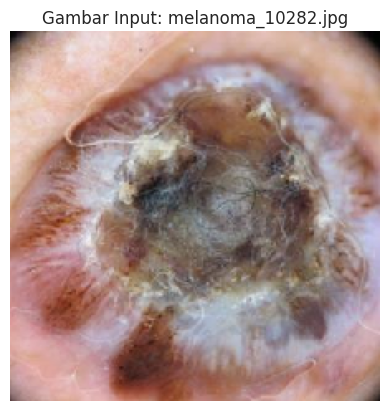

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted class: malignant


In [39]:
# Define the directory you want to sample an image from
test_malignant_dir = 'melanoma_cancer_dataset/test/malignant'

# Get a list of all files in the directory
image_files = os.listdir(test_malignant_dir)

# Check if there are any files in the directory
if len(image_files) > 0:
    # Select a random image file from the list
    random_image_name = random.choice(image_files)

    # Construct the full path to the randomly selected image
    img_path = os.path.join(test_malignant_dir, random_image_name)

    # Load and display the image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Gambar Input: {random_image_name}")
    plt.axis('off')
    plt.show()

    # The rest of your inference code
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = 'malignant' if prediction[0][0] > 0.5 else 'benign'
    print(f'Predicted class: {predicted_class}')

else:
    print(f"No image files found in the directory: {test_malignant_dir}")